In [1]:
from hydra import compose, initialize
from hydra.utils import instantiate

import torch
from torch.distributions import Normal

import bliss

In [2]:
with initialize(config_path="./config"):
     cfg = compose(config_name="config")

In [3]:
cfg

{'mode': 'train', 'gpus': 1, 'paths': {'root': '${oc.env:BLISS_HOME}', 'sdss': '${paths.root}/data/sdss', 'data': '${paths.root}/data', 'project': '${paths.root}/case_studies/sdss_galaxies_vae', 'output': '${paths.project}/output'}, 'datasets': {'sdss_blended_galaxies': {'_target_': 'bliss.datasets.sdss_blended_galaxies.SdssBlendedGalaxies', 'sleep': '${models.sleep}', 'binary_encoder': '${models.binary}', 'sleep_ckpt': '${paths.project}/models/sdss_sleep.pt', 'binary_ckpt': '${paths.project}/models/sdss_binary.pt', 'sdss_dir': '${paths.sdss}', 'prerender_device': 'cuda', 'stride_factor': 0.25}, 'sdss_galaxies': {'_target_': 'bliss.datasets.galsim_galaxies.SDSSGalaxies', 'num_workers': 5, 'batch_size': 64, 'n_batches': 10, 'background': 865, 'slen': 53, 'min_flux': 1000.0, 'max_flux': 350000.0, 'min_a_d': 0.8, 'max_a_d': 6.5, 'min_a_b': 0.8, 'max_a_b': 3.6, 'flux_sample': 'uniform', 'psf_image_file': '${paths.data}/psField-000094-1-0012-PSF-image.npy'}, 'simulated': {'_target_': 'bliss

In [4]:
vae = instantiate(cfg.models.galaxy_vae)

In [6]:
vae.load_state_dict(torch.load(cfg.models.decoder.galaxy_ae_ckpt))

<All keys matched successfully>

In [64]:
import numpy as np
r = np.random.RandomState(1234)
samples = r.standard_normal((10, vae.latent_dim))
samples = torch.from_numpy(samples).to(torch.float32)

In [65]:
samples.shape

torch.Size([10, 32])

In [66]:
with torch.no_grad():
    images = vae.get_decoder()(samples)

In [67]:
images.shape

torch.Size([10, 1, 53, 53])

In [154]:
import numpy as np
from matplotlib import pyplot as plt

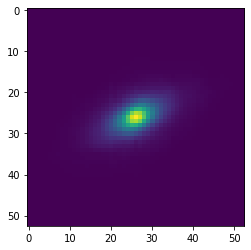

In [164]:
%matplotlib inline
plt.imshow(images[5,0].numpy())

In [166]:
samples[5]

tensor([ 0.5368, -0.7438, -0.3202, -0.9162, -0.8597,  0.2260,  0.6288,  0.1865,
         0.9525,  0.9881, -0.0726, -0.5506, -0.9382, -1.2391,  0.1397, -0.2230,
         2.1237,  0.1223, -1.4094,  1.4230, -2.1479, -1.3475,  0.3636, -0.0148,
         1.2724, -1.4496, -1.1955, -0.5919, -0.4145, -1.4258,  0.2094, -0.5929])

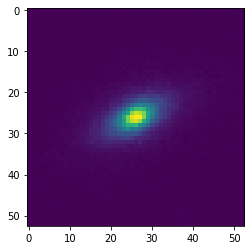

In [167]:
%matplotlib inline
images_noisy = images + images.sqrt() * torch.randn_like(images)
plt.imshow(images_noisy[5,0].numpy())

In [168]:
with torch.no_grad():
    z, _ = vae.get_encoder()(images_noisy[5:6])
    recon_z = vae.get_decoder()(z)
print(z)

tensor([[-0.2286, -0.1901,  0.1358,  0.0177,  1.1454,  0.1924, -1.1612, -0.8904,
          0.9802,  0.4502, -0.8152, -0.7946,  0.3675, -1.1746, -0.9747, -0.1077,
          1.9009,  0.4146, -0.3397, -1.1035, -1.0474,  0.2878,  0.2197, -0.5771,
          0.0781,  0.7441,  0.3550, -0.1884, -1.2131, -0.5655,  0.1395, -0.0625]])


In [169]:
with torch.no_grad():
    z_list = []
    for _ in range(10000):
        z, _ = vae.get_encoder()(images_noisy[5:6])
        z_list.append(z)
    z = torch.cat(z_list, 0)
print(z)
print(z.shape)

tensor([[-7.1554e-01, -1.0931e-01,  1.0318e+00,  ...,  4.2211e-01,
          2.5825e-01, -2.0247e-01],
        [-4.8203e-01,  4.5949e-02,  3.1836e-02,  ..., -1.1036e+00,
          1.8002e-01,  6.3733e-02],
        [-9.0856e-04, -2.2717e-01, -1.0003e+00,  ...,  1.1309e+00,
          8.2503e-02, -3.8701e-01],
        ...,
        [-3.8134e-01, -8.8384e-02, -1.3145e+00,  ..., -1.3494e-01,
          9.6220e-02, -5.1271e-01],
        [-1.0609e+00, -1.9552e-01, -4.9447e-01,  ...,  1.5135e+00,
          3.4997e-01, -3.4285e-01],
        [-6.8710e-01, -2.5906e-01, -1.7564e-01,  ..., -2.6806e-01,
          3.3631e-01, -9.0711e-02]])
torch.Size([10000, 32])


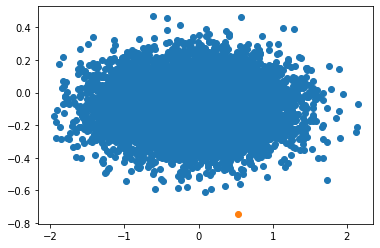

In [174]:
plt.scatter(z[:, 0], z[:, 1])
plt.scatter(samples[5, 0], samples[5, 1])

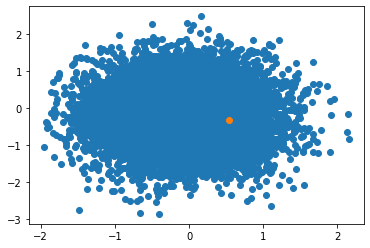

In [176]:
plt.scatter(z[:, 0], z[:, 2])
plt.scatter(samples[5, 0], samples[5, 2])

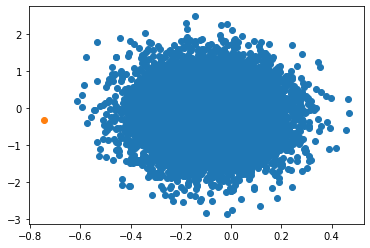

In [178]:
plt.scatter(z[:, 1], z[:, 2])
plt.scatter(samples[5, 1], samples[5, 2])

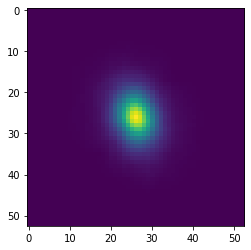

In [163]:
plt.imshow(recon_z[0,0].numpy())

In [183]:
from importlib import reload
reload(reconstruction)

<module 'reconstruction' from '/home/dereklh/projects/bliss/case_studies/sdss_galaxies_vae/reconstruction.py'>

In [328]:
from reconstruction import get_sdss_data, Table, load_models, reconstruct_scene_at_coordinates
from bliss.models.location_encoder import get_images_in_tiles, subtract_bg_and_log_transform

In [329]:
    sdss_data = get_sdss_data(cfg.paths.sdss, cfg.reconstruct.sdss_pixel_scale)
    my_image = torch.from_numpy(sdss_data["image"]).unsqueeze(0).unsqueeze(0)
    my_background = torch.from_numpy(sdss_data["background"]).unsqueeze(0).unsqueeze(0)
    coadd_cat = Table.read(cfg.reconstruct.coadd_cat, format="fits")
    device = torch.device(cfg.reconstruct.device)
    dec, encoder = load_models(cfg, device)

In [330]:
slen=40
h = 1400
h_end = h + slen
w = 1710
w_end = w + slen
recon, tile_map_recon = reconstruct_scene_at_coordinates(
    encoder,
    dec,
    my_image,
    my_background,
    (h, h_end),
    (w, w_end),
    slen=slen,
    device=device,
)

Reconstructing chunks: 1it [00:00, 67.50it/s]


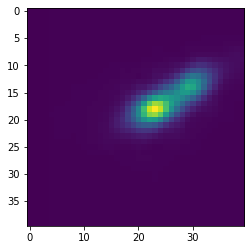

In [331]:
plt.imshow(recon[0,0])

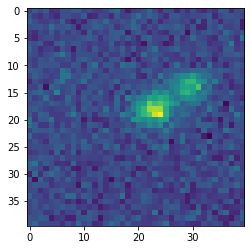

In [332]:
plt.imshow(my_image[0,0,h:h_end,w:w_end])

In [436]:
# for k, v in tile_map_recon.items():
#     print(f"{k}\t: {v.shape}")
    
print(tile_map_recon["galaxy_bools"][0, :, :, 0, 0])

h_mask = 4
w_mask = 5

# h_mask = 3
# w_mask = 7

tile_map_one_galaxy = tile_map_recon.copy()
tile_map_one_galaxy['is_on_array'] = tile_map_one_galaxy['is_on_array'].clone()
tile_map_one_galaxy['galaxy_bools'] = tile_map_one_galaxy['galaxy_bools'].clone()
tile_map_one_galaxy['n_sources'] = tile_map_one_galaxy['n_sources'].clone()
tile_map_one_galaxy['galaxy_bools'][:, h_mask, w_mask] = 0.0
tile_map_one_galaxy['is_on_array'][:, h_mask, w_mask] = 0.0
tile_map_one_galaxy["n_sources"][0, h_mask, w_mask] = 0

# print(tile_map_recon["galaxy_bools"][0, :, :, 0, 0])
# print(tile_map_one_galaxy["galaxy_bools"][0, :, :, 0, 0])
# print(tile_map_one_galaxy["is_on_array"][0, :, :, 0, 0])
# print(tile_map_one_galaxy["star_bools"][0, :, :, 0, 0])


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


In [437]:
recon_one_galaxy = dec.cpu().render_images(
        tile_map_one_galaxy["n_sources"],
        tile_map_one_galaxy["locs"],
        tile_map_one_galaxy["galaxy_bools"],
        tile_map_one_galaxy["galaxy_params"],
        tile_map_one_galaxy["fluxes"],
)
recon_one_galaxy = recon_one_galaxy[:, :, bp:-bp, bp:-bp]

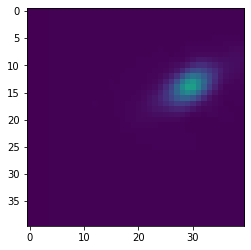

In [438]:
plt.imshow(recon_one_galaxy[0,0] + my_background[0,0,h:h_end,w:w_end], vmax=recon[0,0].max())

In [406]:
# Get padded tiles
bp = 24
example_blend = my_image[:,:,(h - bp):(h_end + bp),(w - bp):(w_end + bp)]
example_bg = my_background[:,:,(h - bp):(h_end + bp),(w - bp):(w_end + bp)]
example_ptiles = get_images_in_tiles(
    subtract_bg_and_log_transform(example_blend, example_bg),
    cfg.models.decoder.tile_slen, 
    cfg.models.decoder.ptile_slen
) 
example_ptiles.shape

torch.Size([1, 10, 10, 1, 52, 52])

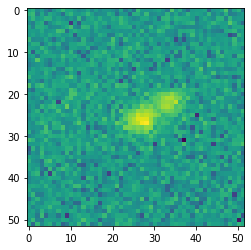

In [335]:
plt.imshow(example_ptiles[0, 4,5, 0])

In [336]:
var_params = encoder.location_encoder.encode(example_ptiles.cuda())

In [337]:
locs = encoder.location_encoder.max_a_post(var_params)

In [338]:
centered_ptiles = encoder.galaxy_encoder.flatten_and_center_ptiles(example_ptiles.cuda(), locs['locs'])

In [339]:
locs['is_on_array'][0, :, :, 0, 0]

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')

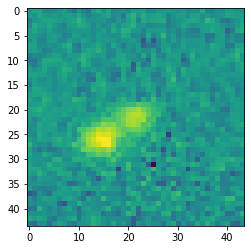

In [342]:
plt.imshow(centered_ptiles[7 + 3 * 10, 0].detach().cpu())

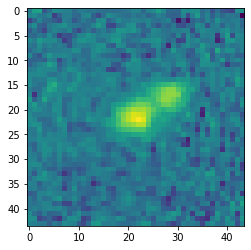

In [343]:
plt.imshow(centered_ptiles[5 + 4 * 10, 0].detach().cpu())

In [346]:
galaxy_probs = encoder.binary_encoder(example_ptiles.cuda(), locs['locs'])
locs['is_on_array'][0, :, :, 0, 0]
(galaxy_probs * locs['is_on_array'])[0, :, :, 0, 0]

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9925, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9999, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]], device='c

In [450]:
with torch.no_grad():
    example_ptiles_no_log = get_images_in_tiles(
        example_blend - example_bg,
        cfg.models.decoder.tile_slen, 
        cfg.models.decoder.ptile_slen
    ) 
    example_bg_tiles = get_images_in_tiles(
        example_bg,
        cfg.models.decoder.tile_slen, 
        cfg.models.decoder.ptile_slen
    )
    centered_ptiles_no_log = encoder.galaxy_encoder.flatten_and_center_ptiles(example_ptiles_no_log.cuda(), locs['locs'])
    galaxy_params = encoder.galaxy_encoder.max_a_post(example_ptiles_no_log.cuda(), locs['locs'])

In [451]:
galaxy_params.shape

torch.Size([1, 10, 10, 1, 32])

In [480]:
galaxy_shapes = dec.galaxy_tile_decoder.galaxy_decoder(galaxy_params.cpu() * locs['is_on_array'].cpu())

In [481]:
galaxy_shapes = galaxy_shapes.reshape(1, 10, 10, 1, 53, 53)

9


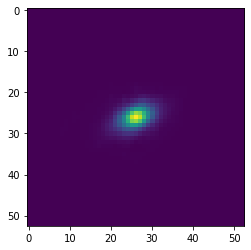

In [484]:
bp = galaxy_shapes.shape[-1] - centered_ptiles.shape[-1]
print(bp)
plt.imshow(galaxy_shapes.detach().cpu()[0, 4, 5, 0])

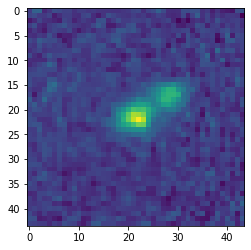

In [483]:
plt.imshow(centered_ptiles_no_log[5 + 4 * 10, 0].detach().cpu())

In [473]:
galaxy_params[0, 4, 5, 0].cpu()

tensor([     0.0018,      0.8023,      0.0333,      0.2268,     -0.0483,
             0.0058,     -0.0008,      0.0132,      0.1535,     -0.0083,
             0.0224,     -0.0769,      0.3641,     -0.0984,      0.0027,
            -0.0234,     -0.0799,      0.0240,      0.0079,      0.0164,
            -0.1033,     -0.0074,     -0.0057,     -0.0074,     -0.0095,
            -0.4544,     -0.0435,     -0.0306,     -0.0086,     -0.0164,
             0.0540,     -0.4650])

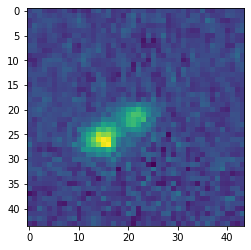

In [440]:
plt.imshow(centered_ptiles_no_log[7 + 3 * 10, 0].detach().cpu())

In [469]:
torch.set_printoptions(sci_mode=False)
galaxy_params[0, 3, 7, 0].cpu()

tensor([-0.0920,  0.8323, -0.0119,  0.3795, -0.0200,  0.0382,  0.0251,  0.0354,
         0.0628,  0.0068, -0.0412,  0.0260,  0.5876,  0.0036,  0.0283,  0.0026,
        -0.3035,  0.0174,  0.0283,  0.1693,  0.0819,  0.0078, -0.1913, -0.0334,
        -0.0603, -0.5298, -0.0083, -0.0214, -0.0242, -0.0132,  0.2987, -0.4653])

In [509]:
dec.cuda()
image_ptiles_recon = dec._render_ptiles(
    locs['n_sources'], locs['locs'], locs['is_on_array'], galaxy_params.cuda(), locs['fluxes']
)
centered_image_ptiles_recon = encoder.galaxy_encoder.flatten_and_center_ptiles(image_ptiles_recon, locs['locs'])

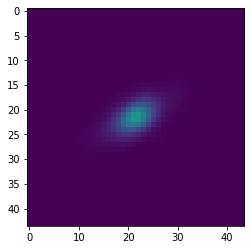

In [517]:
plt.imshow(
    centered_image_ptiles_recon[3*10 + 7, 0].detach().cpu() + my_background[0,0,h:h_end,w:w_end].mean(), 
    vmax=recon[0,0].max()
)

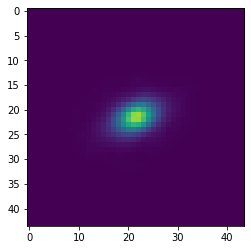

In [518]:
plt.imshow(
    centered_image_ptiles_recon[4*10 + 5, 0].detach().cpu() + my_background[0,0,h:h_end,w:w_end].mean(), 
    vmax=recon[0,0].max()
)